<a href="https://colab.research.google.com/github/BhavyaKohli/Using-facial-features-for-recognition/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
!pip install fastai==2.5.5
!pip install watermark

In [3]:
%load_ext watermark

In [4]:
%watermark -v -p numpy,pandas,fastai,torch

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy : 1.21.6
pandas: 1.3.5
fastai: 2.5.5
torch : 1.10.2



In [6]:
from fastai.vision.all import *
import matplotlib.pyplot as plt

print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.__version__)

True
10.2
1.10.2+cu102


In [7]:
import numpy as np
import pandas as pd

# Exploratory Data Analysis

In [8]:
PROJECT_DIR = "/content/drive/Shareddrives/DS 303 Course Project/"
DATA_DIR = PROJECT_DIR + 'data/'

lookup = pd.read_csv(DATA_DIR + 'IdLookupTable.csv')
train_df = pd.read_csv(DATA_DIR + 'training.zip')
test_df = pd.read_csv(DATA_DIR + 'test.zip')

train_images_df = train_df['Image']
train_points_df = train_df.drop(columns=['Image'])

In [9]:
train_points_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [10]:
mapping = {i: j for i,j in zip(range(30),train_points_df.columns)}
mapping

{0: 'left_eye_center_x',
 1: 'left_eye_center_y',
 2: 'right_eye_center_x',
 3: 'right_eye_center_y',
 4: 'left_eye_inner_corner_x',
 5: 'left_eye_inner_corner_y',
 6: 'left_eye_outer_corner_x',
 7: 'left_eye_outer_corner_y',
 8: 'right_eye_inner_corner_x',
 9: 'right_eye_inner_corner_y',
 10: 'right_eye_outer_corner_x',
 11: 'right_eye_outer_corner_y',
 12: 'left_eyebrow_inner_end_x',
 13: 'left_eyebrow_inner_end_y',
 14: 'left_eyebrow_outer_end_x',
 15: 'left_eyebrow_outer_end_y',
 16: 'right_eyebrow_inner_end_x',
 17: 'right_eyebrow_inner_end_y',
 18: 'right_eyebrow_outer_end_x',
 19: 'right_eyebrow_outer_end_y',
 20: 'nose_tip_x',
 21: 'nose_tip_y',
 22: 'mouth_left_corner_x',
 23: 'mouth_left_corner_y',
 24: 'mouth_right_corner_x',
 25: 'mouth_right_corner_y',
 26: 'mouth_center_top_lip_x',
 27: 'mouth_center_top_lip_y',
 28: 'mouth_center_bottom_lip_x',
 29: 'mouth_center_bottom_lip_y'}

In [11]:
train_df.dtypes

left_eye_center_x            float64
left_eye_center_y            float64
right_eye_center_x           float64
right_eye_center_y           float64
left_eye_inner_corner_x      float64
left_eye_inner_corner_y      float64
left_eye_outer_corner_x      float64
left_eye_outer_corner_y      float64
right_eye_inner_corner_x     float64
right_eye_inner_corner_y     float64
right_eye_outer_corner_x     float64
right_eye_outer_corner_y     float64
left_eyebrow_inner_end_x     float64
left_eyebrow_inner_end_y     float64
left_eyebrow_outer_end_x     float64
left_eyebrow_outer_end_y     float64
right_eyebrow_inner_end_x    float64
right_eyebrow_inner_end_y    float64
right_eyebrow_outer_end_x    float64
right_eyebrow_outer_end_y    float64
nose_tip_x                   float64
nose_tip_y                   float64
mouth_left_corner_x          float64
mouth_left_corner_y          float64
mouth_right_corner_x         float64
mouth_right_corner_y         float64
mouth_center_top_lip_x       float64
m

In [12]:
train_images_df[0]

'238 236 237 238 240 240 239 241 241 243 240 239 231 212 190 173 148 122 104 92 79 73 74 73 73 74 81 74 60 64 75 86 93 102 100 105 109 114 121 127 132 134 137 137 140 139 138 137 137 140 141 143 144 147 148 149 147 147 148 145 147 144 146 147 147 143 134 130 130 128 116 104 98 90 82 78 85 88 86 80 77 87 108 111 115 128 133 188 242 252 250 248 251 250 250 250 235 238 236 238 238 237 238 242 241 239 237 233 215 195 187 156 119 103 93 78 68 73 75 75 72 75 70 61 66 77 91 96 106 108 113 120 125 131 134 138 135 138 139 145 144 144 142 140 141 141 148 147 150 149 152 151 149 150 147 148 144 148 144 146 146 143 139 128 132 135 128 112 104 97 87 78 79 83 85 83 75 75 89 109 111 117 117 130 194 243 251 249 250 249 250 251 237 236 237 238 237 238 241 238 238 238 241 221 195 187 163 124 106 95 81 68 70 73 73 72 73 69 65 74 82 94 103 110 111 119 127 135 140 139 144 144 145 143 143 143 146 144 144 147 146 148 147 150 146 147 150 150 149 147 147 144 147 144 149 146 144 144 144 140 131 133 133 125 110 

The images are stored as strings of numbers separated by a single space (' '), so we can use the `np.fromstring` function to convert it to an array then reshape it into its original size, which is (96,96)

In [13]:
import tqdm.notebook as tq  # For nice progress bars

train_images = [np.fromstring(train_images_df.iloc[i], sep=' ').reshape(96,96) for i in tq.trange(train_images_df.size)]
train_points_1d = [train_points_df.iloc[i].values for i in tq.trange(train_points_df.shape[0])]
train_points = [train_points_df.iloc[i].values.reshape(15,2) for i in tq.trange(train_points_df.shape[0])]

  0%|          | 0/7049 [00:00<?, ?it/s]

  0%|          | 0/7049 [00:00<?, ?it/s]

  0%|          | 0/7049 [00:00<?, ?it/s]

(-0.5, 95.5, 95.5, -0.5)

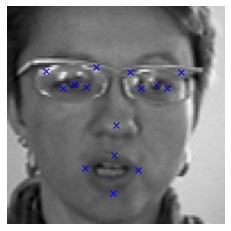

In [14]:
# Visualizing a sample, face and features from the training data
plt.imshow(train_images[10], cmap='gray')
plt.plot(train_points[10][:,0], train_points[10][:,1], 'bx')
plt.axis('off')
plt.show()

In [15]:
def show_image_and_points(img, true_points=None, pred_points=None):
    ax = plt.imshow(img, cmap='gray')
    if true_points is not None:
        plt.plot(true_points[:,0], true_points[:,1], 'bx')
    if pred_points is not None:
        plt.plot(pred_points[:,0], pred_points[:,1], 'bx')
    plt.axis('off')
    plt.show()
def show_test(i):
    pred,_,_ = learner.predict(test_images[i])
    show_image_and_points(test_images[i], pred_points=pred)
def show_train(i, learner=None):
    fully_decoded = None
    if learner is not None:
        fully_decoded, loss_func_decoded, probabilities = learner.predict(train_images[i])
    show_image_and_points(train_images[i], true_points=train_points[i], pred_points=fully_decoded)

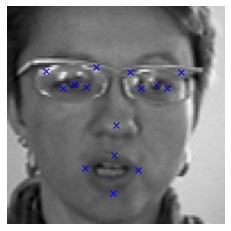

In [16]:
# Testing the function defined above
show_train(10)

# Applying augmentations to the dataset

In [17]:
def augment(img, points, rot_deg, zoom, x_shift_px, y_shift_px):
    size = img.shape[-2:]
    def get_rotation(x):
        size_ = x.new_ones(x.shape[0])
        rot_rad = torch.ones_like(size_)*(rot_deg / 180.0 * np.pi)
        m11 = rot_rad.cos() / zoom
        m12 = rot_rad.sin() / zoom
        t0 = torch.ones_like(size_)*(x_shift_px/48.0)
        t1 = torch.ones_like(size_)*(y_shift_px/48.0)
        return affine_mat(m11, m12, t0, -m12, m11, t1)
    t1 = AffineCoordTfm(aff_fs=get_rotation, size=size)
    p1 = Pipeline(funcs=t1)
    x = TensorImage(img).view([1,1,96,96])
    y = TensorPoint(points, img_size=[96,96]).view([1,15,2])
    x,y = p1((x,y/48.0-1.0))
    y = y.view([15,2])
    coord_ok = (y[:,0] > -1.0) & (y[:,0] < 1.0) & (y[:,1] > -1.0) & (y[:,1] < 1.0)
    coord_ok = torch.stack([coord_ok, coord_ok], dim=1)
    y = y.where(coord_ok, tensor(np.nan))
    y = y*48.0+48.0
    return np.array(x.view([96,96])), np.array(y)

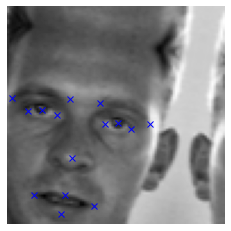

In [18]:
# Testing the augmentation function
aug_img, aug_points = augment(train_images[2], train_points[2], 10.0, 1.0, 16.0, -16.0)
show_image_and_points(aug_img, true_points=aug_points)

In [19]:
augs = []
one_pixel = 2.0/96.0
for dx in range(21):
    for dy in range(21):
        if dx==10 and dy==10:
            continue
        augs.append([0.0, 1.0, dx-10.0, dy-10.0])
for rot_deg in range(21):
    if rot_deg==10:
        continue
    augs.append([rot_deg-10, 1.0, 0.0, 0.0])
for scale in range(21):
    if scale==10:
        continue
    augs.append([0.0, 0.9 + 0.01*scale, 0.0, 0.0])
print(len(augs))

480


In [20]:
aug_images = []
aug_points = []
aug_ind = 0
for idx in tq.trange(len(train_images)):
    img, point = augment(train_images[idx], train_points[idx], *augs[aug_ind])
    aug_images.append(train_images[idx])
    aug_points.append(train_points[idx])
    aug_images.append(img)
    aug_points.append(point)
    aug_ind = (aug_ind + 1) % len(augs)
print(len(aug_images))

  0%|          | 0/7049 [00:00<?, ?it/s]

14098


In [21]:
train_images = aug_images
train_points = aug_points

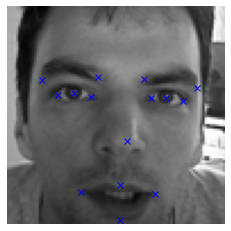

In [22]:
# Unaugmented image
show_train(10)

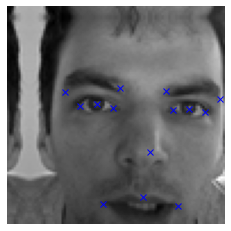

In [23]:
# Augmented image
show_train(11)

# Defining the learner model using the cnn_learner method in `fastai` 

In [24]:
# Defining the loss function class
class MyBaseLoss():
    "Same as my `loss_cls`, but flattens input and target."
    activation=decodes=noops
    def __init__(self, loss_cls, *args, axis=-1, flatten=True, floatify=False, is_2d=True, **kwargs):
        store_attr("axis,flatten,floatify,is_2d")
        self.func = loss_cls(*args,**kwargs)
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"MyFlattenedLoss of {self.func}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v

    def _contiguous(self,x):
        return TensorBase(x.transpose(self.axis,-1).contiguous()) if isinstance(x,torch.Tensor) else x

    def __call__(self, inp, targ, **kwargs):
        inp,targ  = map(self._contiguous, (inp,targ))
        if self.floatify and targ.dtype!=torch.float16: targ = targ.float()
        if targ.dtype in [torch.int8, torch.int16, torch.int32]: targ = targ.long()
        if self.flatten: inp = inp.view(-1,inp.shape[-1]) if self.is_2d else inp.view(-1)
        tmptarg2 = targ.view(inp.shape)
        tmptarg3 = torch.where(torch.isnan(tmptarg2), inp, tmptarg2)
        tmptarg4 = tmptarg3.view(-1) if self.flatten else tmptarg3
        return self.func.__call__(inp, tmptarg4, **kwargs)

In [25]:
@use_kwargs_dict(reduction='mean')
def MyMSELossFlat(*args, axis=-1, floatify=True, **kwargs):
    "Same as MY `nn.MSELoss`, but flattens input and target."
    return MyBaseLoss(nn.MSELoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

In [26]:
def MySplitter(valid_pcts=0.2):
    def _inner(item_range):
        cut = int(len(item_range) * (1.0-valid_pcts))
        mylist = list(item_range)
        l1 = mylist[:cut]
        l2 = mylist[cut:]
        return L(l1), L(l2)
    return _inner

In [27]:
def get_x(ind):
    return train_images[ind]
def get_y(ind):
    return train_points[ind]
def get_items(i): return i
db = DataBlock(blocks=[ImageBlock, PointBlock],
               get_items=get_items,
               get_x=get_x, get_y=get_y,
               item_tfms=Resize([96,96]),
               splitter=MySplitter(0.2),
               batch_tfms=aug_transforms(size=[96,96],
                                         mult=1.0, max_rotate=8.0, 
                                         flip_vert=False,       # Flips set to false since directions (left/right) are sensitive
                                         do_flip=False,         # Same as above
                                         pad_mode='border', 
                                         max_zoom=1.0, min_zoom=0.9, max_lighting=0.1, max_warp=0.0)
              )

In [28]:
db.summary(range(len(train_images)))

Setting-up type transforms pipelines
Found 14098 items
2 datasets of sizes 11278,2820
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> TensorPoint.create

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      0
    applying get_x gives
      [[238. 236. 237. ... 250. 250. 250.]
 [235. 238. 236. ... 249. 250. 251.]
 [237. 236. 237. ... 251. 251. 250.]
 ...
 [186. 183. 181. ...  52.  57.  60.]
 [189. 188. 207. ...  61.  69.  78.]
 [191. 184. 184. ...  70.  75.  90.]]
    applying PILBase.create gives
      PILImage mode=F size=96x96
  Pipeline: get_y -> TensorPoint.create
    starting from
      0
    applying get_y gives
      [[66.03356391 39.00227368]
 [30.22700752 36.4216782 ]
 [59.58207519 39.64742256]
 [73.13034586 39.96999699]
 [36.35657143 37.3894015 ]
 [23.45287218 37.3894015 ]
 [56.95326316 29.03364812]
 [80.22712782 32.22813835]
 [40.22760902 29.0023218 ]
 [16.35637895 29.64747068]
 [44.42057143 57.06680301]
 [61.19530827 79.

In [29]:
dls = db.dataloaders(range(len(train_images)), bs=64)
dls.train_ds.loss_func = MyMSELossFlat()

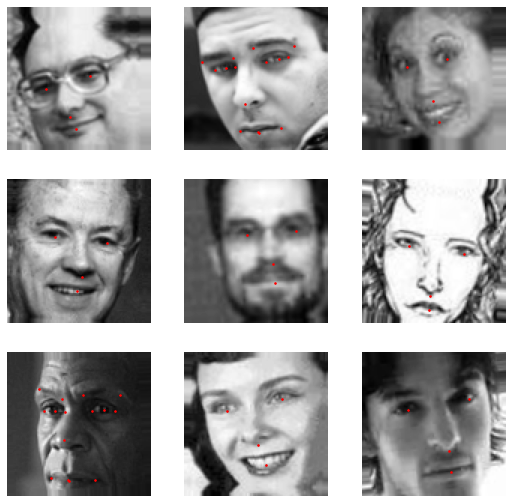

In [30]:
dls.show_batch(cmap='gray', unique=False)

In [31]:
learner = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [32]:
learner.summary()

Sequential (Input shape: 64 x 3 x 96 x 96)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 48 x 48   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 24 x 24   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                        

In [33]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

SuggestedLRs(valley=0.0008317637839354575)

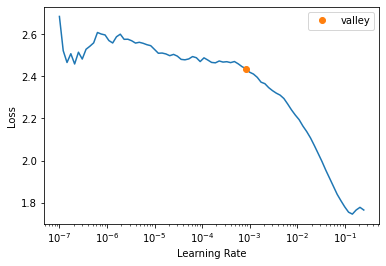

In [34]:
learner.lr_find()

In [35]:
print('Fitting model using lr = 1e-3')
learner.fit_one_cycle(15, lr_max=1e-3)

Fitting model using lr = 1e-3


epoch,train_loss,valid_loss,time
0,1.900235,0.232260,00:50
1,0.998811,0.088872,00:49
2,0.286670,0.022246,01:03
3,0.075733,0.008699,01:06
4,0.030188,0.006032,00:49
5,0.017136,0.007991,00:52
6,0.014138,0.005225,00:52
7,0.012521,0.004506,00:50
8,0.009662,0.003977,00:49
9,0.008860,0.003725,00:49


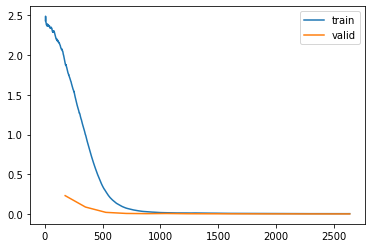

In [36]:
learner.recorder.plot_loss()

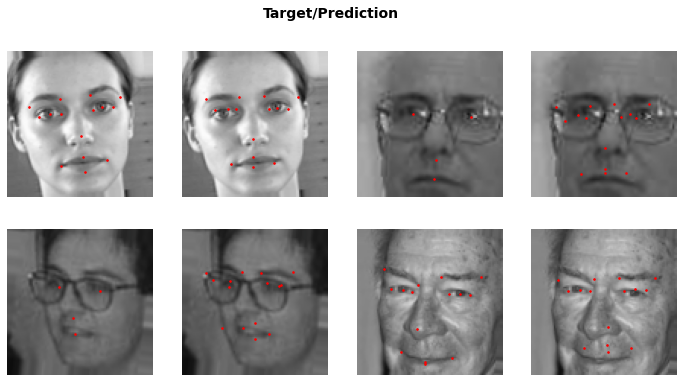

In [38]:
# Visualizing a few images along with the model predictions
learner.show_results(ds_idx=0, shuffle=True, nrows=2, ncols=2)

In [39]:
learner.fine_tune(100)

epoch,train_loss,valid_loss,time
0,0.014606,0.011498,00:51


epoch,train_loss,valid_loss,time
0,0.009538,0.002866,00:54
1,0.007303,0.002656,00:51
2,0.005642,0.002060,00:51
3,0.004654,0.001749,00:51
4,0.004053,0.001692,00:51
5,0.003800,0.001779,00:57
6,0.003545,0.001345,00:51
7,0.003450,0.001335,00:51
8,0.003322,0.001452,00:51
9,0.003281,0.001691,00:51


In [40]:
learner.export(PROJECT_DIR + 'models/model.pkl')

In [44]:
learner.save(PROJECT_DIR + 'models/model_save')

Path('/content/drive/Shareddrives/DS 303 Course Project/models/model_save.pth')

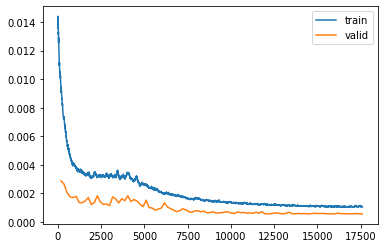

In [43]:
learner.recorder.plot_loss()